# Recreation of XGBoost Model Study

This is a comprehensive recreation of the influential study on the XGBoost model, originally presented in:

**Li, H., Cao, Y., Li, S., Zhao, J., & Sun, Y. (2020). XGBoost model and its application to personal credit evaluation. IEEE Intelligent Systems, 35(3), 52-61.**

The purpose of this research is to reproduce the findings of the original study, delving into the intricacies of the XGBoost model and exploring its robust application in the field of personal credit evaluation. This model has gained significant attention for its efficiency and performance in predictive modeling, particularly in financial contexts.

The original study utilized a dataset from Lending Club, a popular peer-to-peer lending platform. Unfortunately, the direct access to this specific dataset is no longer available. However, thanks to the data-sharing community on Kaggle, we can still access a similar dataset. You can find the dataset we will be using [here](https://www.kaggle.com/datasets/wordsforthewise/lending-club/data).

Through this notebook, we aim to:

- Provide a detailed recreation of the study's methodology and analysis process.
- Compare our results with those obtained in the original study to assess consistency and accuracy.
- Highlight the challenges and considerations in replicating real-world studies.
- Offer insights into the practical implications of the findings for credit evaluation.

## Authors

This project is a collaborative effort by a dedicated team of data science enthusiasts:

- **Adam Janczyszyn**
- **Hubert Wojewoda**
- **Jakub Wujec**
- **Jakub Żmujdzin**


### Data Loading

To begin the analysis, we need to load the dataset from Kaggle. Ensure you have the necessary libraries installed and the dataset downloaded.


In [1]:
import pandas as pd

df = pd.read_csv("data/credit_card_2018.csv")

C:\Users\krzyr\AppData\Local\Temp\ipykernel_13744\41789672.py:3: DtypeWarning: Columns (129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/credit_card_2018.csv")


Once the dataset is loaded, we proceed to preprocess the data in accordance with the methodology outlined in the original study. This involves several critical steps.

Firstly, we map the target variable to binary values (0 and 1). Following this, we implement a monthly sampling strategy where we select four times as many good clients as bad clients. This is essential for balancing the dataset and aligning it with the approach used in the study.

To facilitate our analysis, we have prepared many functions, encapsulated in .py files located within the rr_project folder. These functions streamline various preprocessing tasks, ensuring consistency and efficiency.


In [2]:
from rr_project.data_wrangling import preprocess_data

preprocessed_df = preprocess_data(df)

Source data shape: (127702, 153). 
Source data target distribution:
0    124626
1      3076
Name: target, dtype: int64
Bads for month 1: 420. Goods for month 1: 1680.
Bads for month 2: 323. Goods for month 2: 1292.
Bads for month 3: 390. Goods for month 3: 1560.
Bads for month 4: 394. Goods for month 4: 1576.
Bads for month 5: 361. Goods for month 5: 1444.
Bads for month 6: 310. Goods for month 6: 1240.
Bads for month 7: 271. Goods for month 7: 1084.
Bads for month 8: 213. Goods for month 8: 852.
Bads for month 9: 136. Goods for month 9: 544.
Bads for month 10: 133. Goods for month 10: 532.
Bads for month 11: 80. Goods for month 11: 320.
Bads for month 12: 45. Goods for month 12: 180.
Undersampled data shape: (15380, 153). 
Undersampled data target distribution:
0    12304
1     3076
Name: target, dtype: int64


### Addressing Initial Discrepancies

At this stage, we encounter some discrepancies compared to the original study:

- While the number of rows remains consistent, our dataset contains 10 additional columns (153 vs. 143). These extra columns are primarily metadata (e.g., download URL) and will be excluded from the analysis.
- There is a notable difference in the number of "bad" clients. The original authors classified "Fully Paid", "Current", and "In Grace Period" as good clients, categorizing all others as bad clients. However, the original study reported over 5,000 defaults, whereas our dataset has just over 3,000. Consequently, our overall sampled row count decreases from approximately 25,000 to about 15,000.


### Feature Selection for Preprocessing

Next, we conduct feature selection as part of our preprocessing. The original authors manually excluded over 30 columns and removed all features with a NaN proportion exceeding 0.5. We will adhere to this methodology to maintain consistency with the study.


In [3]:
from rr_project.data_wrangling import preprocessing_feature_selection

feature_selected_df = preprocessing_feature_selection(preprocessed_df)

print("Feature selected data shape: ", feature_selected_df.shape)

Features with over 50% missing values = 37. Index(['member_id', 'desc', 'orig_projected_additional_accrued_interest',
       'hardship_type', 'hardship_last_payment_amount',
       'hardship_payoff_balance_amount', 'hardship_loan_status',
       'hardship_dpd', 'hardship_length', 'hardship_amount', 'deferral_term',
       'hardship_status', 'hardship_reason', 'settlement_percentage',
       'settlement_amount', 'settlement_status', 'settlement_term',
       'sec_app_mths_since_last_major_derog', 'verification_status_joint',
       'sec_app_revol_util', 'sec_app_collections_12_mths_ex_med',
       'sec_app_open_acc', 'annual_inc_joint', 'dti_joint',
       'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts',
       'sec_app_open_act_il', 'sec_app_fico_range_high', 'sec_app_mort_acc',
       'sec_app_inq_last_6mths', 'sec_app_fico_range_low', 'revol_bal_joint',
       'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_last_major_derog', 'mths_since_recent_re

### Label Encoding

In the subsequent step, the authors mentioned converting text data to numeric data, though they did not specify the exact method. We opted to use `LabelEncoder` from `sklearn.preprocessing`, which efficiently encodes categorical labels to numeric values. We will also display the encodings for transparency. Null values in these columns will be filled with 0.


In [4]:
from rr_project.data_wrangling import label_encode_all

label_encoded_df = label_encode_all(feature_selected_df)

print("Label encoded data shape: ", label_encoded_df.shape)

Encoding for column 'term': {' 36 months': 0, ' 60 months': 1}
Encoding for column 'grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Encoding for column 'emp_length': {'0': 0, '1 year': 1, '10+ years': 2, '2 years': 3, '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, '7 years': 8, '8 years': 9, '9 years': 10, '< 1 year': 11}
Encoding for column 'home_ownership': {'ANY': 0, 'MORTGAGE': 1, 'OWN': 2, 'RENT': 3}
Encoding for column 'verification_status': {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
Encoding for column 'pymnt_plan': {'n': 0, 'y': 1}
Encoding for column 'title': {'Credit card refinancing': 0}
Encoding for column 'application_type': {'Individual': 0, 'Joint App': 1}
Encoding for column 'hardship_flag': {'N': 0, 'Y': 1}
Encoding for column 'disbursement_method': {'Cash': 0, 'DirectPay': 1}
Encoding for column 'debt_settlement_flag': {'N': 0, 'Y': 1}
Label encoded data shape:  (15380, 84)


### Handling Missing Values

To handle missing values, we fill null entries with the mean of the respective columns, ensuring our dataset remains intact for subsequent analysis.


In [5]:
from rr_project.data_wrangling import fill_nulls_with_mean

wrangled_df = fill_nulls_with_mean(label_encoded_df)

print("Filled nulls data shape: ", wrangled_df.shape)

Filled nulls data shape:  (15380, 84)


### Selection by Information Value (IV)

Finally, we perform variable selection based on Information Value (IV), as described in the study. IV involves binning continuous variables and calculating the Weight of Evidence (WoE) for each bin. The IV is then determined as the sum of the differences between the WoE and the natural logarithm of the proportion of good clients to bad clients, serving as a measure of a variable's predictive power. The authors selected variables with an IV over 0.02. Lacking specific binning details from the study, we opt for decile binning for variables with more than 10 distinct values; otherwise, each distinct value forms a separate bin.


In [6]:
from rr_project.data_wrangling import iv_selection

df_iv_selection, iv_values = iv_selection(wrangled_df, "target")

print("IV selected data shape: ", df_iv_selection.shape)

                Variable        IV
0               int_rate  0.533063
0                  grade  0.492798
0   debt_settlement_flag  0.143604
0         fico_range_low  0.118618
0        fico_range_high  0.118618
..                   ...       ...
0     num_tl_90g_dpd_24m  0.000000
0                  title  0.000000
0       num_tl_120dpd_2m  0.000000
0            policy_code  0.000000
0                  month  0.000000

[83 rows x 2 columns]
Variables with IV lower than threshold:  ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'title', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'open_act_il', 'total_bal_il', 'all_util', 'total_cu_tl', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 

### Addressing Collinearity
After selecting variables based on IV, the next step is to address collinearity. Collinear variables can distort model performance and lead to overfitting. To ensure the robustness of our analysis, we remove highly collinear variables.

- **Identify Collinear Variables**: Using the IV values, we identify variables that exhibit high collinearity.
- **Remove Collinear Variables**: We systematically remove these variables to retain only those that contribute uniquely to the model.


In [7]:
from rr_project.data_wrangling import remove_collinear_variables

filtered_df, dropped_columns = remove_collinear_variables(df_iv_selection, iv_values)

print("Filtered data shape: ", filtered_df.shape)
print("Dropped columns due to collinearity: ", dropped_columns)

Dropped grade due to high correlation with int_rate and lower IV.
Dropped fico_range_high due to high correlation with fico_range_low and lower IV.
Dropped open_il_24m due to high correlation with open_il_12m and lower IV.
Dropped open_rv_12m due to high correlation with open_acc_6m and lower IV.
Dropped open_rv_12m due to high correlation with open_rv_24m and lower IV.
Dropped open_rv_12m due to high correlation with acc_open_past_24mths and lower IV.
Dropped open_rv_24m due to high correlation with acc_open_past_24mths and lower IV.
Dropped tot_cur_bal due to high correlation with avg_cur_bal and lower IV.
Dropped total_rev_hi_lim due to high correlation with bc_open_to_buy and lower IV.
Dropped mo_sin_rcnt_rev_tl_op due to high correlation with mo_sin_rcnt_tl and lower IV.
Dropped mths_since_recent_bc due to high correlation with mo_sin_rcnt_rev_tl_op and lower IV.
Dropped num_tl_op_past_12m due to high correlation with open_acc_6m and lower IV.
Dropped open_rv_12m due to high corre

The output shows that several variables were dropped due to high correlation with others and lower Information Value (IV). These dropped variables included those highly correlated with key features like `int_rate`, `fico_range_low`, and `total_bc_limit`, among others. The filtered dataset now has 15,380 rows and 26 columns. Now we can be sure that only the most predictive and non-redundant features are retained for further analysis.

In [8]:
from rr_project.split_data import split_data

X_train, X_test, y_train, y_test = split_data(
    filtered_df.drop(["target"], axis=1), filtered_df["target"]
)

X_train

,term,int_rate,installment,emp_length,home_ownership,verification_status,fico_range_low,inq_last_6mths,open_acc_6m,open_il_12m,...,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_inq,tot_hi_cred_lim,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
20066,1,10.42,300.37,3,3,1,755.0,0.0,0.0,0.0,...,0.0,119.582577,448.0,331.0,19.000000,15000.0,15000.0,0,0,0
107643,0,15.49,209.44,4,3,1,665.0,1.0,1.0,0.0,...,2.0,45.000000,32.0,3.0,4.000000,2900.0,2900.0,0,0,0
69392,1,10.72,324.05,11,3,0,775.0,0.0,1.0,0.0,...,4.0,133.000000,283.0,2.0,7.581323,131738.0,60300.0,0,0,0
60747,0,16.14,317.04,2,1,0,690.0,0.0,0.0,0.0,...,5.0,115.000000,48.0,8.0,11.000000,142458.0,14000.0,0,1,0
2974,1,6.71,393.30,2,1,1,705.0,0.0,1.0,1.0,...,4.0,142.000000,151.0,4.0,7.000000,279200.0,33300.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17483,1,23.88,516.58,4,3,0,670.0,0.0,1.0,2.0,...,5.0,123.000000,37.0,6.0,6.000000,70432.0,16000.0,0,0,0
31958,1,16.14,609.82,11,1,1,685.0,1.0,4.0,0.0,...,7.0,125.000000,81.0,2.0,2.000000,568832.0,50500.0,0,0,0
4340,0,15.04,693.70,2,1,1,690.0,0.0,2.0,1.0,...,6.0,139.000000,253.0,1.0,8.000000,177591.0,8000.0,0,0,0
113741,1,10.90,347.09,2,1,1,680.0,0.0,3.0,1.0,...,7.0,176.000000,92.0,4.0,2.000000,193640.0,11500.0,0,0,0


In [9]:
from rr_project.train_models import train_and_save_models

train_and_save_models(X_train, y_train)

Model logistic_regression_model has been trained and saved successfully.
Model decision_tree_model has been trained and saved successfully.
Model random_forest_model has been trained and saved successfully.
Model gradient_boosting_model has been trained and saved successfully.
Model xgboost_model has been trained and saved successfully.


AttributeError: 'DataFrame' object has no attribute 'y_true'

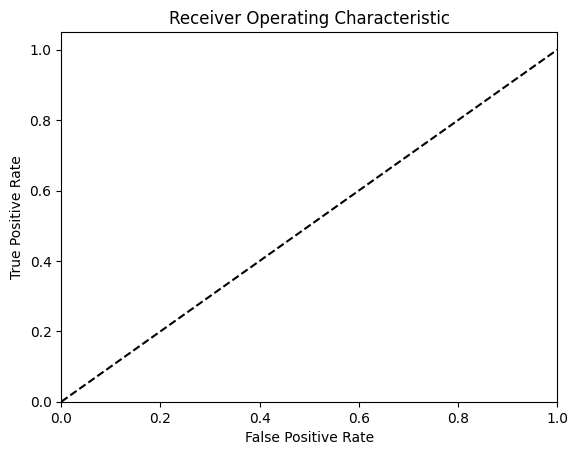

In [10]:
from rr_project.visualization import get_roc_for_multiple_models

get_roc_for_multiple_models(X_test, y_test)